# Clustering Subset

Goal - Cluster the users based on the count of symptoms they have had.

User selection criteria - users have recorded more than 30 days of symptoms (does not need to be continuous)

In [1]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from sensorfabric.athena import athena

In [3]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [33]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [34]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [35]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [36]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

In [37]:
# Run the query to get the symptom count for all the users who have recorded at least 30 days of symptom data in total.
users = db.execQuery("""
                    select s.uid, s.name, count(s.name) count from symptoms s 
                    inner join 
                    (select uid from symptoms_sum
                    where days_symptoms_recorded >= 30) ss
                    on s.uid = ss.uid
                    group by s.uid, s.name
                    order by s.uid, count(s.name) desc
                    """, cached=True)
print(users.shape)

(11748, 3)


In [38]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(users['uid'].values, users['name'].values, users['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [39]:
frame.head()

hot_flashes  bloating  nipple_discharge  anxiety  \
uid                                                                          
5f8e90320054a6c5fab1544e           26        19                17       17   
5f9384efa42cd9d7053ec233           10         2                 0        1   
5f9605bea42cd9d7053ec2bb            2        19                 0        1   
5f963cb3a42cd9d7053ec2c5            1         2                 0        2   
5f98b34c44eca8ead4eca1f1           76        19                 0       39   

                          insomnia  breast_swelling  dry_skin  depression  \
uid                                                                         
5f8e90320054a6c5fab1544e        11               11        10           6   
5f9384efa42cd9d7053ec233         0               24         0           0   
5f9605bea42cd9d7053ec2bb         1                0         3           1   
5f963cb3a42cd9d7053ec2c5         1                0         0           3   
5f98b34c44eca8ead4eca1f1        23                0        18          33   

                          odor  dry_eyes  ...  constipation  nausea  fatigue  \
uid                                       ...                                  
5f8e90320054a6c5fab1544e     6         6  ...             0       0        0   
5f9384efa42cd9d7053ec233     0         0  ...             1       0        0   
5f9605bea42cd9d7053ec2bb     0         8  ...             0       6        0   
5f963cb3a42cd9d7053ec2c5     0         2  ...             2       2       11   
5f98b34c44eca8ead4eca1f1    11        17  ...             7      11       44   

                          diarrhea  vertigo  ringing_ears  vomiting  \
uid                                                                   
5f8e90320054a6c5fab1544e         0        0             0         0   
5f9384efa42cd9d7053ec233         0        0             0         0   
5f9605bea42cd9d7053ec2bb         0        0             0         0   
5f963cb3a42cd9d7053ec2c5         0        0             0         0   
5f98b34c44eca8ead4eca1f1         2        1             0         0   

                          yeast_infection  vaginal_dryness  uti  
uid                                                              
5f8e90320054a6c5fab1544e                0                0    0  
5f9384efa42cd9d7053ec233                0                0    0  
5f9605bea42cd9d7053ec2bb                0                0    0  
5f963cb3a42cd9d7053ec2c5                0                0    0  
5f98b34c44eca8ead4eca1f1                0                0    0  

[5 rows x 45 columns]

In [40]:
frame.shape

(627, 45)

## Covariance matrix of the features

Standardize the features first.

In [41]:
sframe = frame[symptoms]
sframe = (sframe - sframe.mean()) / sframe.std()

In [42]:
data_type = frame[symptoms].dtypes
print(data_type)


allergies               int64
anxiety                 int64
bloating                int64
brain_fog               int64
breast_pain             int64
breast_swelling         int64
brittle_nails           int64
chills                  int64
constipation            int64
cramps                  int64
depression              int64
diarrhea                int64
dizzy                   int64
dry_eyes                int64
dry_skin                int64
facial_hair             int64
fatigue                 int64
hair_loss               int64
headaches               int64
heartburn               int64
hot_flashes             int64
incontinence            int64
insomnia                int64
irregular_beat          int64
itchy_skin              int64
joint_pain              int64
memory_lapse            int64
mood_swings             int64
muscle_tension          int64
nausea                  int64
night_sweats            int64
nipple_discharge        int64
odor                    int64
ovulation 

## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


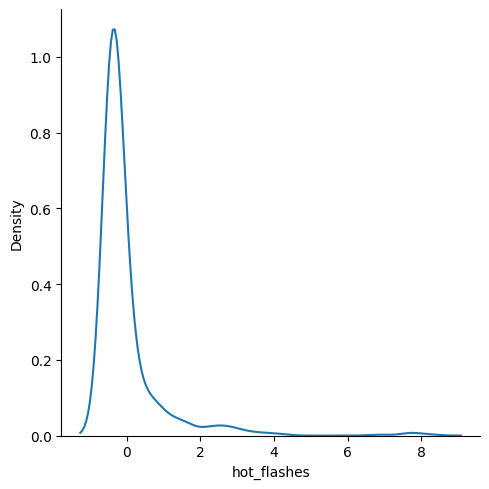

In [43]:
sns.displot(sframe, x='hot_flashes', kind='kde')

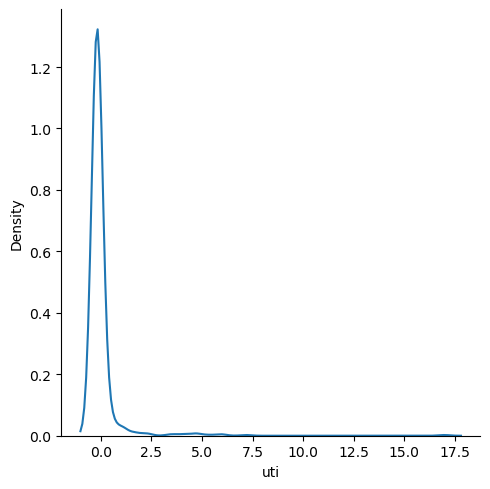

In [ ]:
sns.displot(sframe, x='uti', kind='kde')

In [44]:
cmatrix = sframe.cov()

In [45]:
cmatrix.to_csv('csv/symptom_covariance.csv', index=True)

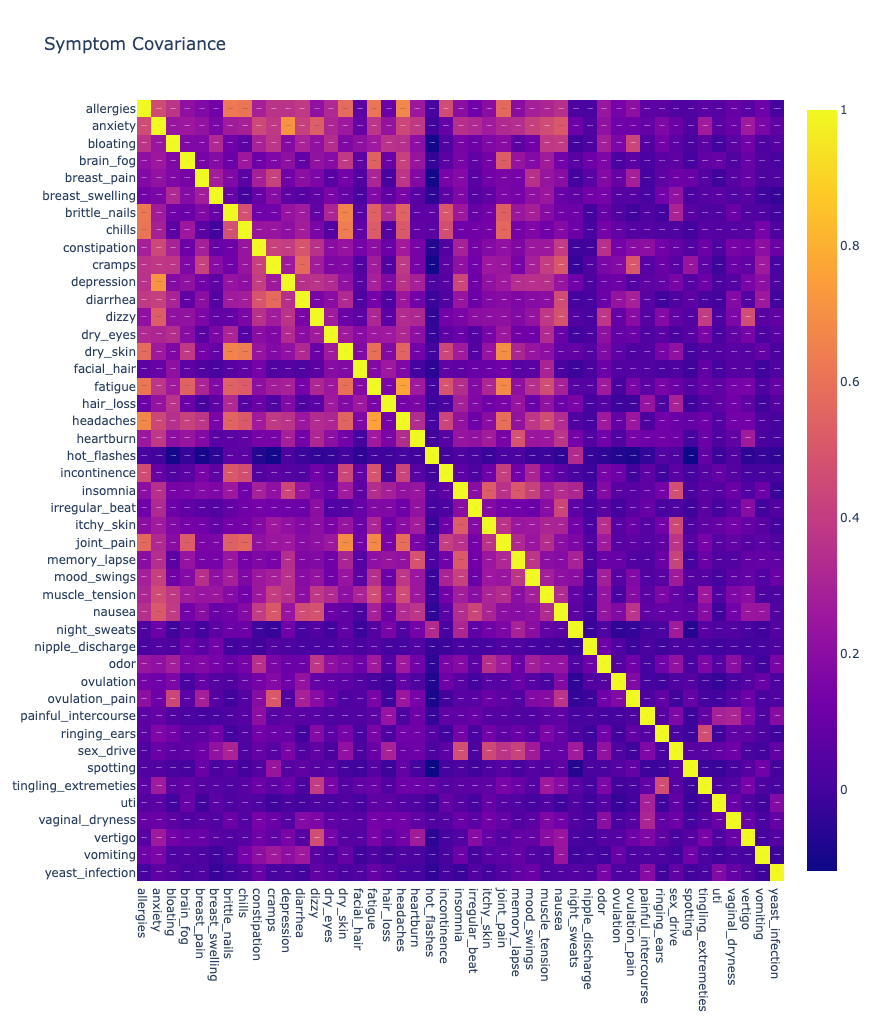

In [46]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('figures/symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

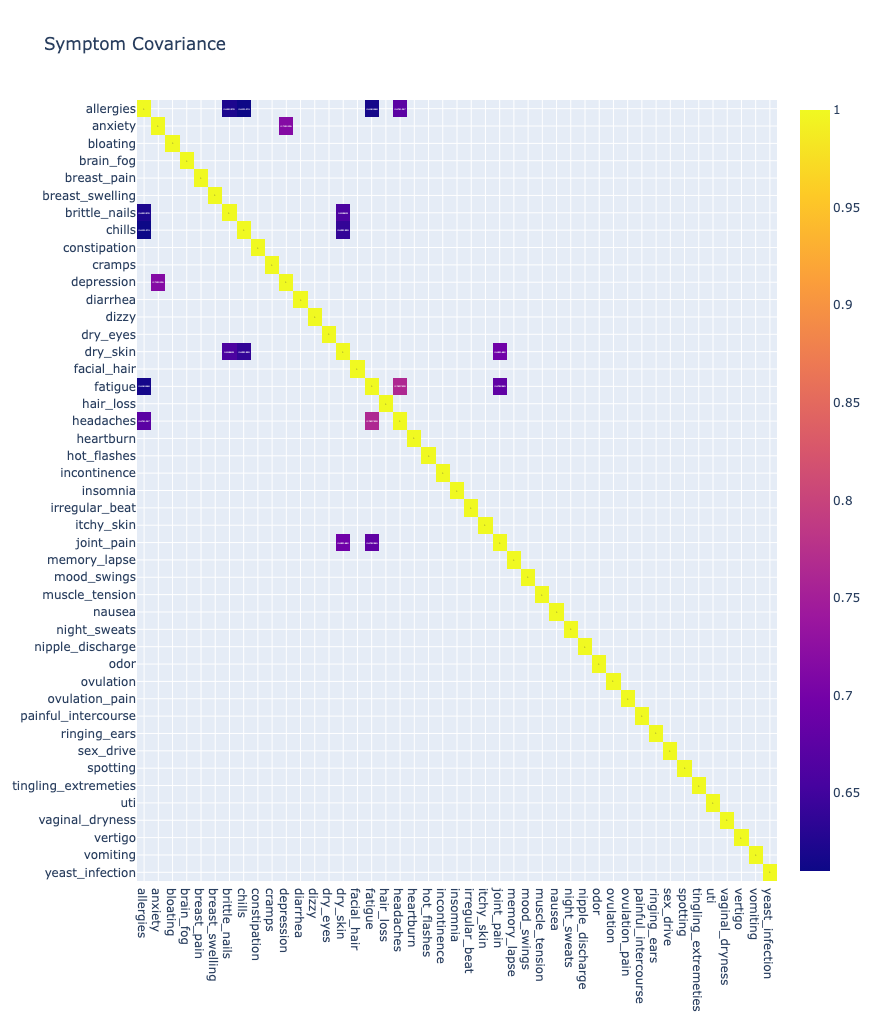

allergies - brittle_nails - 0.6220577884565078
allergies - chills - 0.6101074100060424
allergies - fatigue - 0.6163468314658913
allergies - headaches - 0.6741047016195938
anxiety - depression - 0.7150135775440322
brittle_nails - allergies - 0.6220577884565078
brittle_nails - dry_skin - 0.6596989989153101
chills - allergies - 0.6101074100060424
chills - dry_skin - 0.6391999128144012
depression - anxiety - 0.7150135775440322
dry_skin - brittle_nails - 0.6596989989153101
dry_skin - chills - 0.6391999128144012
dry_skin - joint_pain - 0.6951682096293513
fatigue - allergies - 0.6163468314658913
fatigue - headaches - 0.7637437909489737
fatigue - joint_pain - 0.6792965226663054
headaches - allergies - 0.6741047016195938
headaches - fatigue - 0.7637437909489737
joint_pain - dry_skin - 0.6951682096293513
joint_pain - fatigue - 0.6792965226663054


In [47]:
th = 0.6
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    paired = fmatrix[s].dropna().index.values
    # We can go ahead print it out. 
    for p in paired:
        if not (s == p):
            print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

## Cluster Map

In [50]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

RuntimeError: clustermap requires scipy to be available

In [ ]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

In [ ]:
#hcluster.savefig('figures/symptom_co_hirach.png')

## Perform PCA analysis on the data.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [ ]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [ ]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [ ]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.39, 0.39
PCA2 - 0.25, 0.64
PCA3 - 0.05, 0.69
PCA4 - 0.04, 0.73
PCA5 - 0.03, 0.76
PCA6 - 0.03, 0.79
PCA7 - 0.02, 0.81
PCA8 - 0.02, 0.83
PCA9 - 0.02, 0.85
PCA10 - 0.02, 0.87
PCA11 - 0.02, 0.88
PCA12 - 0.01, 0.90
PCA13 - 0.01, 0.91
PCA14 - 0.01, 0.92
PCA15 - 0.01, 0.93


Looks like we would need 12 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (64%), while an 80% variance is represented by 7 components.

In [ ]:
pcacomponents = pca.fit_transform(X)

In [ ]:
pcacomponents.shape

(627, 15)

In [ ]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

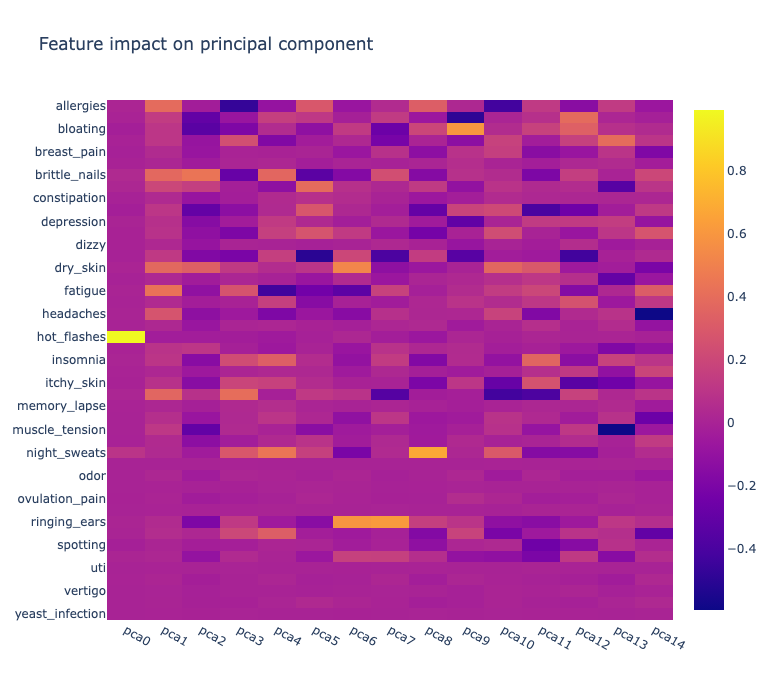

In [ ]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

For the clustering we just pick the components that give 80% variance

In [ ]:
pca = PCA(n_components=7, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(627, 7)

In [ ]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

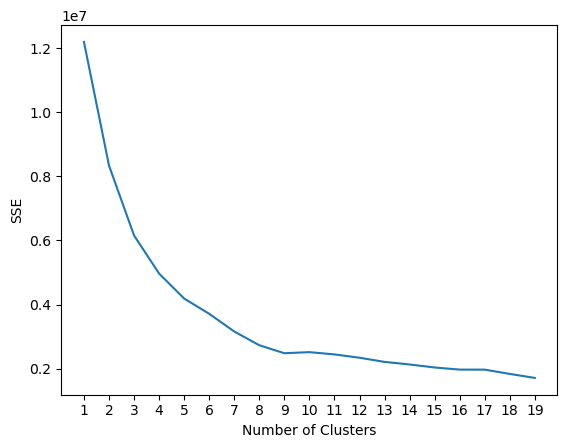

In [ ]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

5

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **5**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

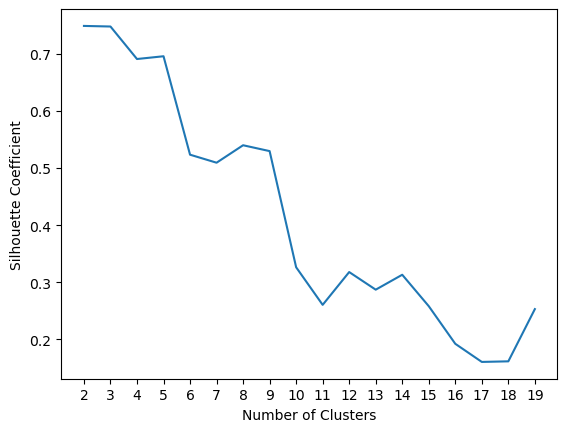

In [ ]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=3 and then for n=5.
n=3 might be too small of a number of clusters. We will pick n=5 based on the elbow method + S method.

## Cluster them using k-means clustering

In [ ]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 5
1 - 47
2 - 545
3 - 25
4 - 5


## Get the users which belong to each of these clusters

In [ ]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [ ]:
def getTopSymptoms(users, top=5):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [ ]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['joint_pain' 'fatigue' 'dry_skin' 'brittle_nails' 'allergies']
Segment 1
['hot_flashes' 'night_sweats' 'chills' 'ringing_ears'
 'tingling_extremeties']
Segment 2
['hot_flashes' 'fatigue' 'headaches' 'bloating' 'joint_pain']
Segment 3
['allergies' 'fatigue' 'dry_eyes' 'headaches' 'bloating']
Segment 4
['hot_flashes' 'night_sweats' 'irregular_beat' 'headaches' 'chills']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

## Alternatively if we use n=3 for segmentation

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 573
1 - 37
2 - 17
Segment 0
['hot_flashes' 'fatigue' 'headaches' 'bloating' 'joint_pain']
Segment 1
['hot_flashes' 'night_sweats' 'chills' 'ringing_ears'
 'tingling_extremeties']
Segment 2
['fatigue' 'brittle_nails' 'allergies' 'dry_skin' 'joint_pain']


In [ ]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from sensorfabric.athena import athena

In [ ]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [ ]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [ ]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [ ]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

In [ ]:
# Run the query to get the symptom count for all the users who have recorded at least 30 days of symptom data in total.
users = db.execQuery("""
                    select s.uid, s.name, count(s.name) count from symptoms s 
                    inner join 
                    (select uid from symptoms_sum
                    where days_symptoms_recorded >= 30) ss
                    on s.uid = ss.uid
                    group by s.uid, s.name
                    order by s.uid, count(s.name) desc
                    """, cached=True)
print(users.shape)

(11748, 3)


In [ ]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(users['uid'].values, users['name'].values, users['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [ ]:
frame.head()

hot_flashes  bloating  anxiety  nipple_discharge  \
uid                                                                          
5f8e90320054a6c5fab1544e           26        19       17                17   
5f9384efa42cd9d7053ec233           10         2        1                 0   
5f9605bea42cd9d7053ec2bb            2        19        1                 0   
5f963cb3a42cd9d7053ec2c5            1         2        2                 0   
5f98b34c44eca8ead4eca1f1           76        19       39                 0   

                          insomnia  breast_swelling  dry_skin  odor  \
uid                                                                   
5f8e90320054a6c5fab1544e        11               11        10     6   
5f9384efa42cd9d7053ec233         0               24         0     0   
5f9605bea42cd9d7053ec2bb         1                0         3     0   
5f963cb3a42cd9d7053ec2c5         1                0         0     0   
5f98b34c44eca8ead4eca1f1        23                0        18    11   

                          depression  dry_eyes  ...  constipation  nausea  \
uid                                             ...                         
5f8e90320054a6c5fab1544e           6         6  ...             0       0   
5f9384efa42cd9d7053ec233           0         0  ...             1       0   
5f9605bea42cd9d7053ec2bb           1         8  ...             0       6   
5f963cb3a42cd9d7053ec2c5           3         2  ...             2       2   
5f98b34c44eca8ead4eca1f1          33        17  ...             7      11   

                          fatigue  diarrhea  vertigo  ringing_ears  vomiting  \
uid                                                                            
5f8e90320054a6c5fab1544e        0         0        0             0         0   
5f9384efa42cd9d7053ec233        0         0        0             0         0   
5f9605bea42cd9d7053ec2bb        0         0        0             0         0   
5f963cb3a42cd9d7053ec2c5       11         0        0             0         0   
5f98b34c44eca8ead4eca1f1       44         2        1             0         0   

                          yeast_infection  vaginal_dryness  uti  
uid                                                              
5f8e90320054a6c5fab1544e                0                0    0  
5f9384efa42cd9d7053ec233                0                0    0  
5f9605bea42cd9d7053ec2bb                0                0    0  
5f963cb3a42cd9d7053ec2c5                0                0    0  
5f98b34c44eca8ead4eca1f1                0                0    0  

[5 rows x 45 columns]

In [ ]:
frame.shape

(627, 45)

## Covariance matrix of the features

Standardize the features first.

In [ ]:
sframe = frame[symptoms]
sframe = (sframe - sframe.mean()) / sframe.std()

## Visualizing the distribution of some of the symptoms

Hotflashes

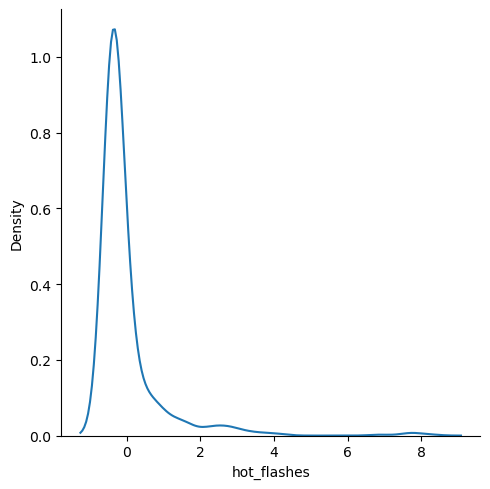

In [ ]:
sns.displot(sframe, x='hot_flashes', kind='kde')

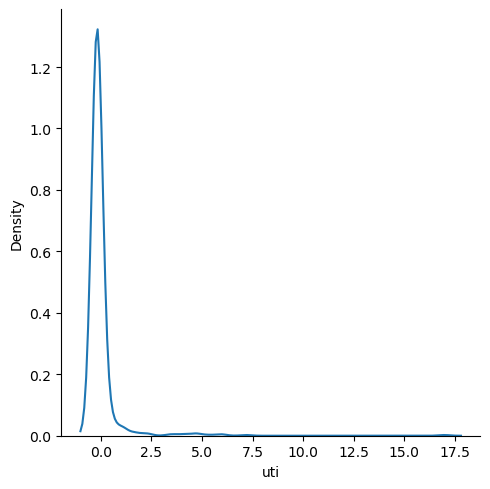

In [ ]:
sns.displot(sframe, x='uti', kind='kde')

In [ ]:
cmatrix = sframe.cov()

In [ ]:
cmatrix.to_csv('csv/symptom_covariance.csv', index=True)

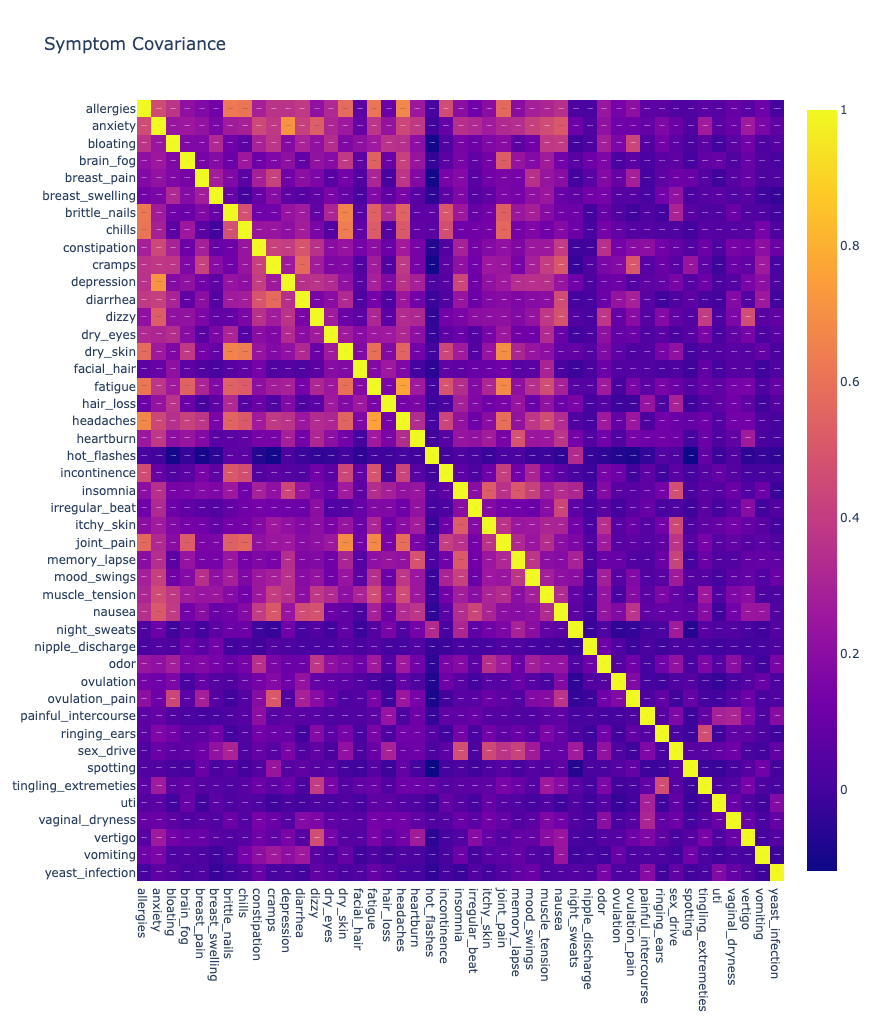

In [ ]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('figures/symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

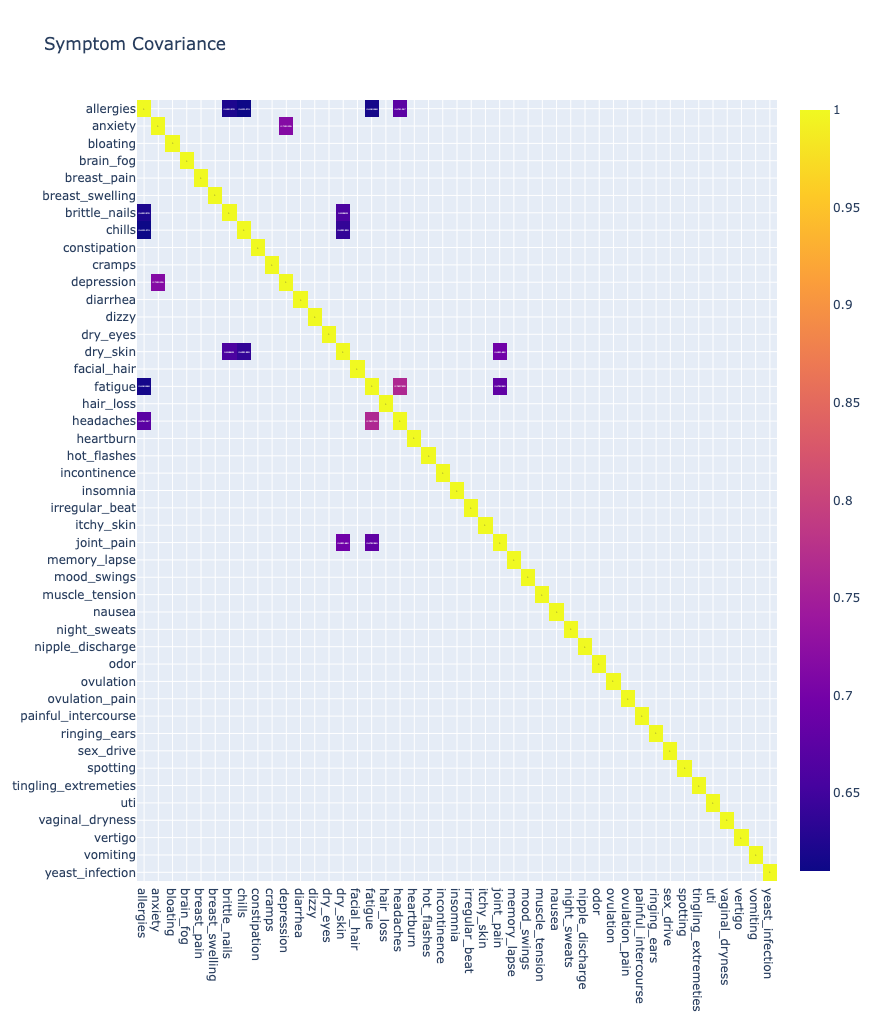

allergies - brittle_nails - 0.6220577884565085
allergies - chills - 0.6101074100060412
allergies - fatigue - 0.6163468314658913
allergies - headaches - 0.6741047016195935
anxiety - depression - 0.7150135775440322
brittle_nails - allergies - 0.6220577884565085
brittle_nails - dry_skin - 0.6596989989153108
chills - allergies - 0.6101074100060412
chills - dry_skin - 0.6391999128144026
depression - anxiety - 0.7150135775440322
dry_skin - brittle_nails - 0.6596989989153108
dry_skin - chills - 0.6391999128144026
dry_skin - joint_pain - 0.6951682096293508
fatigue - allergies - 0.6163468314658913
fatigue - headaches - 0.763743790948973
fatigue - joint_pain - 0.6792965226663052
headaches - allergies - 0.6741047016195935
headaches - fatigue - 0.763743790948973
joint_pain - dry_skin - 0.6951682096293508
joint_pain - fatigue - 0.6792965226663052


In [ ]:
th = 0.6
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    paired = fmatrix[s].dropna().index.values
    # We can go ahead print it out. 
    for p in paired:
        if not (s == p):
            print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

## Cluster Map

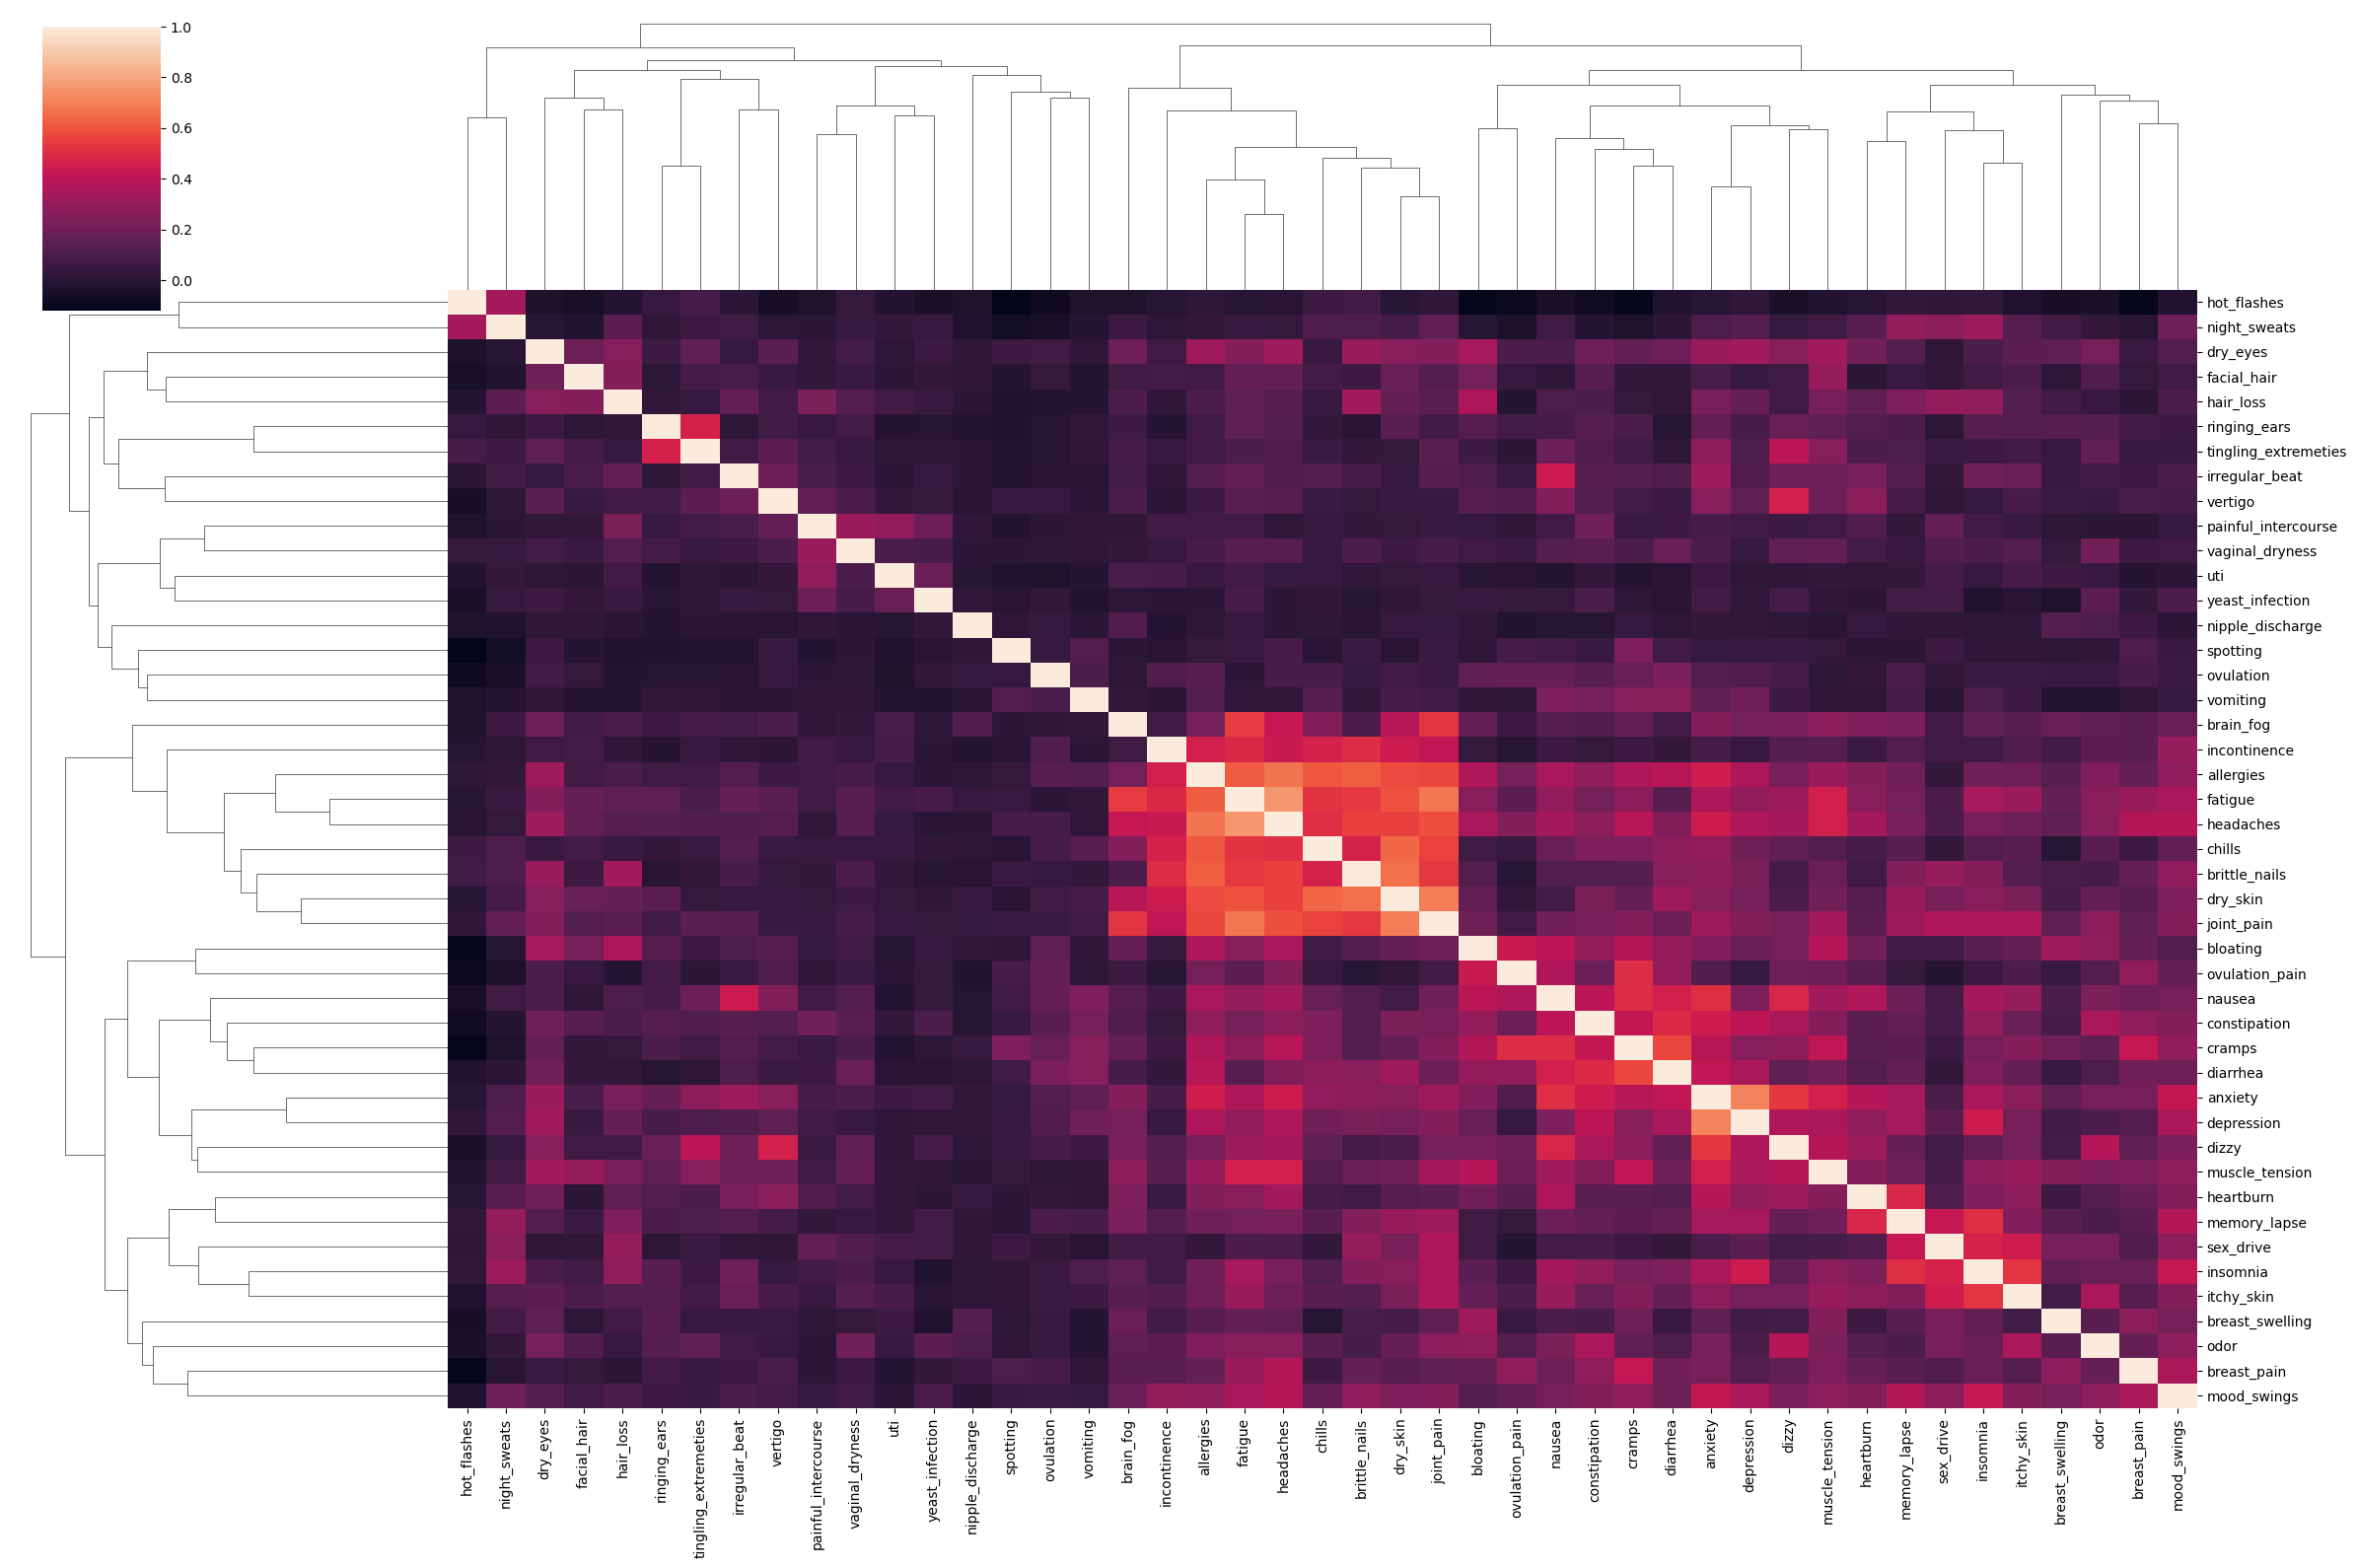

In [ ]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [ ]:
#hcluster.savefig('figures/symptom_co_hirach.png')

## Perform PCA analysis on the data.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [ ]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [ ]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [ ]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.39, 0.39
PCA2 - 0.25, 0.64
PCA3 - 0.05, 0.69
PCA4 - 0.04, 0.73
PCA5 - 0.03, 0.76
PCA6 - 0.03, 0.79
PCA7 - 0.02, 0.81
PCA8 - 0.02, 0.83
PCA9 - 0.02, 0.85
PCA10 - 0.02, 0.87
PCA11 - 0.02, 0.88
PCA12 - 0.01, 0.90
PCA13 - 0.01, 0.91
PCA14 - 0.01, 0.92
PCA15 - 0.01, 0.93


Looks like we would need 12 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (64%), while an 80% variance is represented by 7 components.

In [ ]:
pcacomponents = pca.fit_transform(X)

In [ ]:
pcacomponents.shape

(627, 15)

In [ ]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

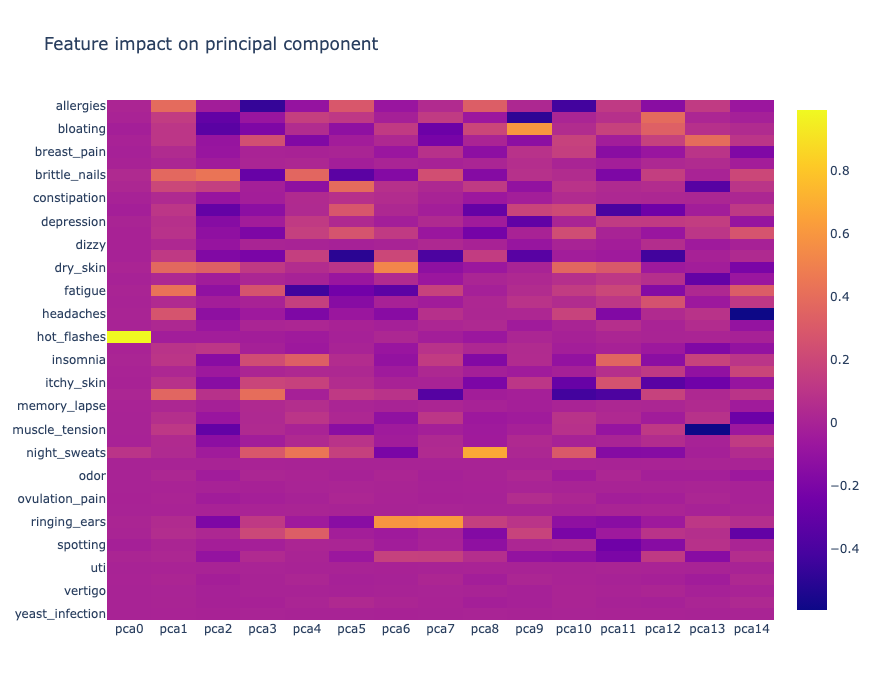

In [ ]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

For the clustering we just pick the components that give 80% variance

In [ ]:
pca = PCA(n_components=7, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(627, 7)

In [ ]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

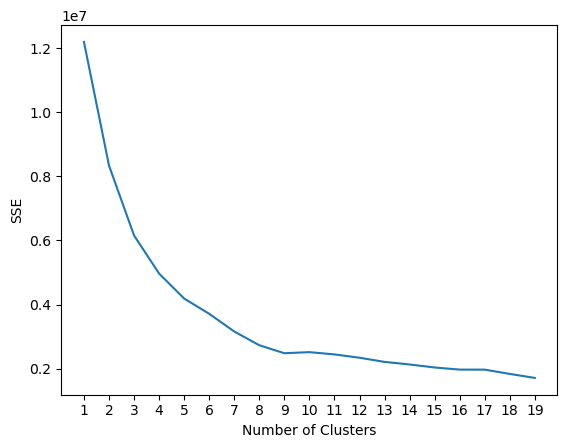

In [ ]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

5

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **5**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

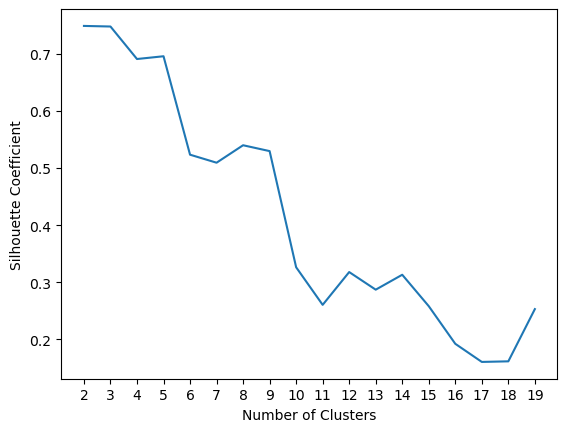

In [ ]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=3 and then for n=5.
n=3 might be too small of a number of clusters. We will pick n=5 based on the elbow method + S method.

## Cluster them using k-means clustering

In [ ]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 5
1 - 47
2 - 545
3 - 25
4 - 5


## Get the users which belong to each of these clusters

In [ ]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [ ]:
def getTopSymptoms(users, top=5):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [ ]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['joint_pain' 'fatigue' 'dry_skin' 'brittle_nails' 'allergies']
Segment 1
['hot_flashes' 'night_sweats' 'chills' 'ringing_ears'
 'tingling_extremeties']
Segment 2
['hot_flashes' 'fatigue' 'headaches' 'bloating' 'joint_pain']
Segment 3
['allergies' 'fatigue' 'dry_eyes' 'headaches' 'bloating']
Segment 4
['hot_flashes' 'night_sweats' 'irregular_beat' 'headaches' 'chills']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

## Alternatively if we use n=3 for segmentation

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 573
1 - 37
2 - 17
Segment 0
['hot_flashes' 'fatigue' 'headaches' 'bloating' 'joint_pain']
Segment 1
['hot_flashes' 'night_sweats' 'chills' 'ringing_ears'
 'tingling_extremeties']
Segment 2
['fatigue' 'brittle_nails' 'allergies' 'dry_skin' 'joint_pain']
